# Compare Gradient Descent Variations

This Notebook will explore the differences between traditional (Batch) Gradient Descent, Stochastic Gradient Descent and Mini-Batch Gradient Descent.

## Background

## Generate our dummy data

In [243]:
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook

In [244]:
# number of random data points to generate
N = 10000

In [245]:
# generate array of random floats for our independent variable, x (values between 0 and 1 as default)
x = np.random.rand(N)
x = np.array(sorted(x))

In [246]:
# to make this a bit more interesting than a simple linear problem, we will also introduce an x^2 dependency
x2 = np.square(x)

In [247]:
# define our parameter values that will be used to generate our dependent variable values, y
a0, a1, a2 = 3, 2, -5

In [248]:
# generate our y values based on our x values, our parameters and introduce some noise (we don't want perfect data!)
y = a0 + a1*x + a2*x2 + np.random.normal(0, 0.2, N)

In [249]:
# also allow ourselves to plot our underlying distribution
y_curve = a0 + a1*x + a2*x2

<IPython.core.display.Javascript object>


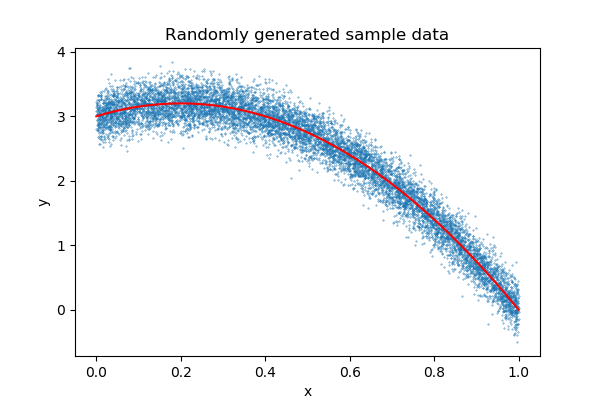

In [250]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Randomly generated sample data')

plt.plot(x, y_curve, color="red")
plt.scatter(x, y, marker='o', s=0.1)

## Create X matrix for use in Gradient Descent

In [251]:
def X_for_gd(x, x2):
    
    X = np.concatenate((np.ones(len(x)).reshape(-1, 1), x.reshape(-1, 1)), axis=1)
    X = np.concatenate((X, x2.reshape(-1, 1)), axis=1)
    
    return X

## Cost Function

In [276]:
def cost(X, y, theta):
    
    m = len(y)
    h = X.dot(theta)
    
    return (1/(2*m))* np.sum( (h-y)**2 )

In [277]:
X = X_for_gd(x, x2)
theta = np.random.rand(1, X.shape[1])
theta = list(theta[0])

In [278]:
print(cost(X, y, theta))

1.7357355104132313


## Batch Gradient Descent

In [285]:
def batch_gd(X, y, theta, alpha=0.01, num_iter=100):
    
    m = len(y)
    cost_record = np.empty(num_iter)
    theta_record = np.empty((num_iter, len(theta)))
    
    for i in range(num_iter):
        h = X.dot(theta)
        
        theta = theta - (alpha/m) * (X.T.dot((h-y)))
        theta_record[i, :] = theta.T
        
        c = cost(X, y, theta)
        cost_record[i] = c
        
    return theta, c, cost_record, theta_record

In [300]:
opt_theta, final_cost, cost_rec, theta_rec = batch_gd(X, y, theta, alpha=0.1, num_iter=1000)

<IPython.core.display.Javascript object>


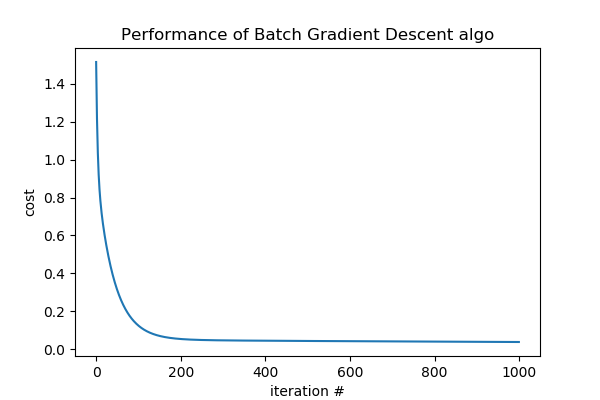

In [301]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('iteration #')
ax.set_ylabel('cost')
ax.set_title('Performance of Batch Gradient Descent algo')

plt.plot(np.arange(0, len(cost_rec)), cost_rec)